<a href="https://colab.research.google.com/github/rmonro12/Intro_to_ML/blob/main/Homework_Assignments/HW_5/Problem_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ryan Monroe (801219572) - 11/10/2025 <br>
ECGR 4105 - Homework 5, Problem 3

In [40]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [41]:
#Import .csv dataset from class repository
url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv'
df = pd.read_csv(url)
#print(df.head()) #Confirm successful import by printing

In [42]:
#Assign input and output variables
X = df.iloc[:, [1, 2, 3, 4, 10]].values #input
Y = df.iloc[:, 0].values #output

X = torch.tensor(X)
Y = torch.tensor(Y)

In [43]:
#Manipulate dataset
n_samples = X.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# Separate into training and validation
train_X_raw = X[train_indices].float()
train_Y_raw = Y[train_indices].float()
val_X_raw = X[val_indices].float()
val_Y_raw = Y[val_indices].float()

# Standardize input features
# Calculate mean and std dev only from training data to avoid data leakage
mu_X = train_X_raw.mean(dim=0)
sigma_X = train_X_raw.std(dim=0)

train_X = (train_X_raw - mu_X) / sigma_X
val_X = (val_X_raw - mu_X) / sigma_X

# Standardize output target (price)
mu_Y = train_Y_raw.mean()
sigma_Y = train_Y_raw.std()

train_Y = (train_Y_raw - mu_Y) / sigma_Y
val_Y = (val_Y_raw - mu_Y) / sigma_Y


In [44]:
import torch.nn as nn

# Define the neural network model
class Net(nn.Module):
    def __init__(self, n_input_features):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_input_features, 8) # First hidden layer
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(8, 8) # Second hidden layer
        self.relu2 = nn.ReLU()
        self.hidden3 = nn.Linear(8, 8) # Third hidden layer
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(8, 1) # Output layer

    def forward(self, x):
        # Ensure input x is float for nn.Linear
        x = self.relu1(self.hidden1(x.float()))
        x = self.relu2(self.hidden2(x))
        x = self.relu3(self.hidden3(x))
        x = self.output(x)
        return x

In [45]:
#Define loss function
def loss(Y_pred, Y):
  squared_diffs = (Y_pred - Y) ** 2
  return squared_diffs.mean()

In [46]:
#Define training loop
def training_loop(n_epochs, optimizer, model_nn, train_X, val_X, train_Y, val_Y):
  train_losses = []
  val_losses = []
  for epoch in range(1, n_epochs + 1):
    # Store model predictions in new variables to avoid overwriting input data
    train_Y_pred = model_nn(train_X)
    # Ensure train_Y is float for loss calculation and squeeze to match dimensions
    train_loss = loss(train_Y_pred.squeeze(), train_Y.float())
    train_losses.append(train_loss.item())

    val_Y_pred = model_nn(val_X)
    # Ensure val_Y is float for loss calculation and squeeze to match dimensions
    val_loss = loss(val_Y_pred.squeeze(), val_Y.float())
    val_losses.append(val_loss.item())

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    if epoch <= 3 or epoch % 200 == 0:
      print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}")
  return model_nn, train_losses, val_losses # Return the trained model and losses

In [47]:
# Determine the number of input features from train_X
n_input_features = train_X.shape[1]

# Initialize the neural network model
model_nn = Net(n_input_features)

learning_rate = 0.01 # Adjusted learning rate, often works well with scaled data
optimizer = torch.optim.SGD(model_nn.parameters(), lr=learning_rate)

model_nn, train_losses, val_losses = training_loop(
    n_epochs = 200,
    optimizer = optimizer,
    model_nn = model_nn, # Pass the model instance
    train_X = train_X,
    val_X = val_X,
    train_Y = train_Y,
    val_Y = val_Y)


Epoch 1, Training loss 0.9982, Validation loss 1.3193
Epoch 2, Training loss 0.9966, Validation loss 1.3168
Epoch 3, Training loss 0.9951, Validation loss 1.3143
Epoch 200, Training loss 0.7701, Validation loss 1.0265


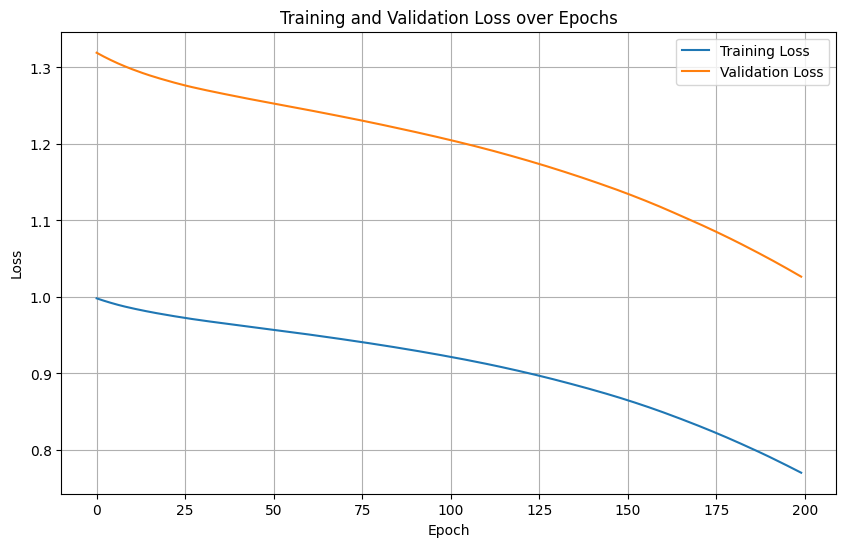

In [48]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()